<a href="https://colab.research.google.com/github/Vastalya1/MiniProject4/blob/master/UNET_CNN_ROI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os

# Path to the ZIP file (replace with your uploaded file name)
zip_file_path = "patches.zip"  # Example: oil-spill-detection.zip

# Extraction path
extract_folder = "patches"  # Folder where the dataset will be extracted

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"✅ Dataset extracted to: {extract_folder}")


✅ Dataset extracted to: patches


In [ ]:
# List files in the extracted folder
for root, dirs, files in os.walk(extract_folder):
    print(f"Folder: {root}")
    print(f"Subfolders: {dirs}")
    print(f"Files: {files}")
    print('-' * 50)


Folder: patches
Subfolders: ['patches']
Files: []
--------------------------------------------------
Folder: patches/patches
Subfolders: ['masks', 'images']
Files: []
--------------------------------------------------
Folder: patches/patches/masks
Subfolders: []
Files: ['Oil_8_water_640_896.png', 'Oil_8_water_640_0.png', 'Oil_496_oil_1280_640.png', 'Oil_8_water_256_512.png', 'Oil_263_background_512_768.png', 'Oil_140_background_1280_384.png', 'Oil_8_water_512_640.png', 'Oil_270_oil_640_768.png', 'Oil_8_water_896_512.png', 'Oil_7_water_640_0.png', 'Oil_140_other_1408_0.png', 'Oil_141_background_0_384.png', 'Oil_5_oil_1152_896.png', 'Oil_141_background_256_512.png', 'Oil_8_other_1792_128.png', 'Oil_263_water_512_896.png', 'Oil_141_other_1408_384.png', 'Oil_8_water_128_384.png', 'Oil_5_water_512_640.png', 'Oil_8_water_640_768.png', 'Oil_496_oil_640_384.png', 'Oil_7_background_1792_512.png', 'Oil_5_oil_1024_384.png', 'Oil_5_water_768_256.png', 'Oil_5_water_1280_128.png', 'Oil_141_backgroun

In [ ]:
import os
import cv2
import numpy as np

# Map color to label
color_to_label = {
    (0, 0, 0): 0,         # Background
    (255, 0, 124): 1,      # Oil
    (255, 204, 51): 2,     # Others
    (51, 221, 255): 3      # Water
}


In [ ]:
import os
import cv2
import numpy as np

IMG_SIZE = (128, 128)

# Function to load images and masks
def load_images_and_masks(image_folder, mask_folder):
    images = []
    masks = []

    for img_name in os.listdir(image_folder):
        img_path = os.path.join(image_folder, img_name)
        mask_path = os.path.join(mask_folder, img_name)  # Mask has the same name

        # Load image
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Load mask
        mask = cv2.imread(mask_path)
        mask = cv2.resize(mask, IMG_SIZE)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # Convert mask colors to class labels
        label_map = np.zeros((IMG_SIZE[0], IMG_SIZE[1]), dtype=np.uint8)

        for color, label in color_to_label.items():
            mask_mask = np.all(mask == color, axis=-1)
            label_map[mask_mask] = label

        # Append the image and mask
        images.append(img / 255.0)  # Normalize images
        masks.append(label_map)

    return np.array(images), np.array(masks)


In [ ]:
# Replace with your dataset paths
image_folder = r"/content/patches/patches/images"
mask_folder = r"/content/patches/patches/masks"

# Load the images and masks
X, y = load_images_and_masks(image_folder, mask_folder)

# Print the shape
print(f"Images shape: {X.shape}")
print(f"Masks shape: {y.shape}")


Images shape: (1204, 128, 128, 3)
Masks shape: (1204, 128, 128)


In [ ]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the masks
y_encoded = to_categorical(y, num_classes=4)

# Print the shape
print("Masks shape after one-hot encoding:", y_encoded.shape)


Masks shape after one-hot encoding: (1204, 128, 128, 4)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (963, 128, 128, 3) (963, 128, 128, 4)
Testing set shape: (241, 128, 128, 3) (241, 128, 128, 4)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout

def build_segmentation_model(input_shape=(128, 128, 3), num_classes=4):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c2 = Dropout(0.1)(c2)
    c2 = MaxPooling2D((2, 2))(c2)

    # Decoder
    u1 = UpSampling2D((2, 2))(c2)
    u1 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)

    u2 = UpSampling2D((2, 2))(u1)
    u2 = Conv2D(32, (3, 3), activation='relu', padding='same')(u2)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(u2)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Build the model with 128x128 input size
model = build_segmentation_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 4)    │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,916 (292.64 KB)

 Trainable params: 74,916 (292.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 349ms/step - accuracy: 0.3512 - loss: 1.3384 - val_accuracy: 0.4400 - val_loss: 1.2813
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.4399 - loss: 1.2651 - val_accuracy: 0.5328 - val_loss: 1.2155
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5058 - loss: 1.2002 - val_accuracy: 0.5240 - val_loss: 1.1675
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.4961 - loss: 1.2032 - val_accuracy: 0.5561 - val_loss: 1.0633
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6070 - loss: 0.9889 - val_accuracy: 0.4422 - val_loss: 1.2462
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.6369 - loss: 0.9877 - val_accuracy: 0.6928 - val_loss: 0.8647
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7192 - loss: 0.7907 - val_accuracy: 0.7325 - val_loss: 0.7976
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7355 - loss: 0.7548 - val_accuracy: 0.6532 -

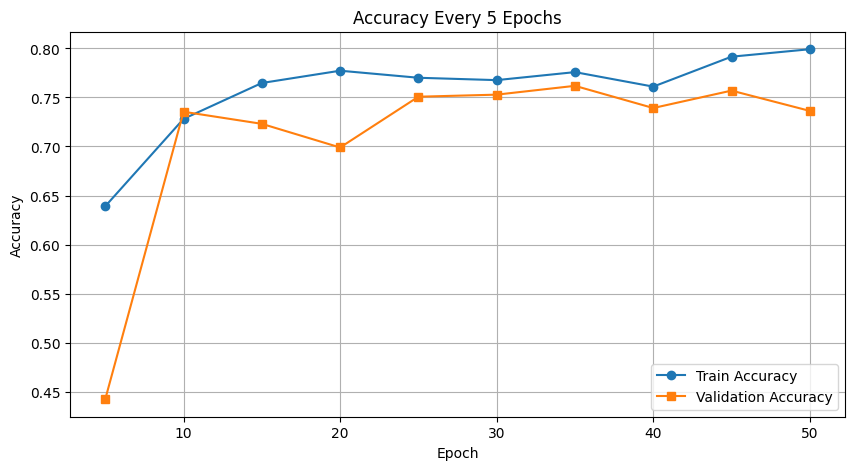

In [ ]:
# Train the model
import matplotlib.pyplot as plt

# Train the model and get the history
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test)
)

# Extract accuracy and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Store accuracy at every 5 epochs
epochs = list(range(5, 51, 5))
train_acc_every_5 = [train_acc[i - 1] for i in epochs]
val_acc_every_5 = [val_acc[i - 1] for i in epochs]

# Plot the accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc_every_5, marker='o', label='Train Accuracy')
plt.plot(epochs, val_acc_every_5, marker='s', label='Validation Accuracy')
plt.title('Accuracy Every 5 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate on the test set
# Extract final metrics
train_acc_final = history.history['accuracy'][-1]
val_acc_final = history.history['val_accuracy'][-1]
train_loss_final = history.history['loss'][-1]
val_loss_final = history.history['val_loss'][-1]

# Print them
print(f'Final Training Accuracy: {train_acc_final:.4f}')
print(f'Final Training Loss: {train_loss_final:.4f}')

print(f'Final Validation Accuracy: {val_acc_final:.4f}')
print(f'Final Validation Loss: {val_loss_final:.4f}')


Final Training Accuracy: 0.8215
Final Training Loss: 0.4401
Final Validation Accuracy: 0.7982
Final Validation Loss: 0.4882


In [ ]:
# Save the model
model.save("oil_spill_segmentation_model_128x128.h5")
print("Model saved successfully!")


Model saved successfully!


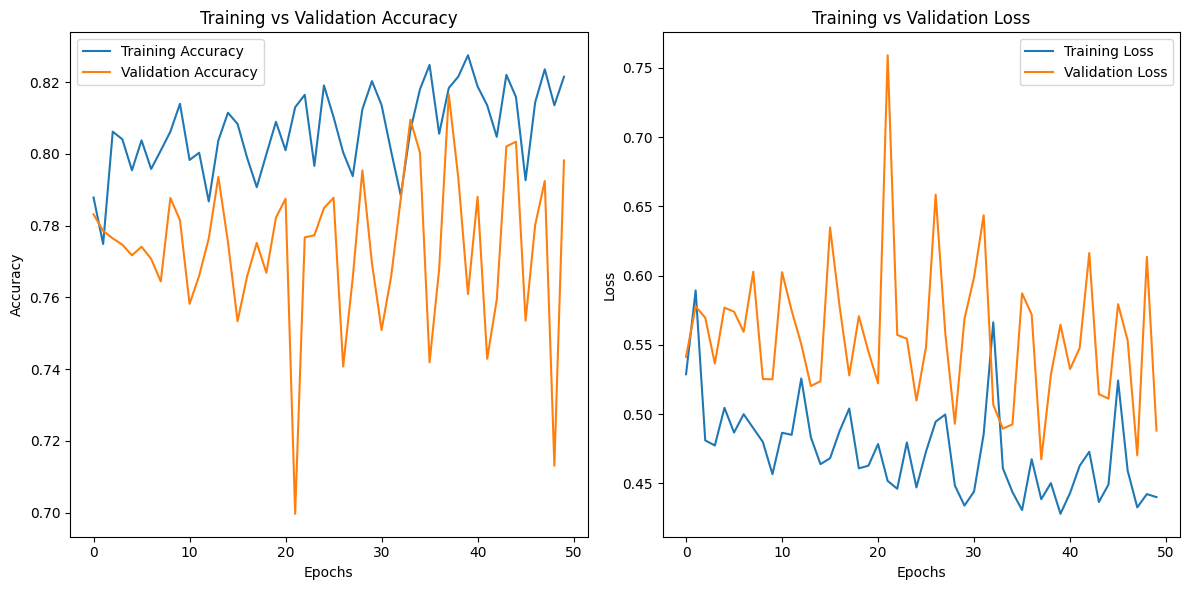

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


testing

In [ ]:
import zipfile
import os

# Path to the ZIP file (replace with your uploaded file name)
zip_file_path = "Testpatches.zip"  # Example: oil-spill-detection.zip

# Extraction path
extract_folder = "Testpatches"  # Folder where the dataset will be extracted

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"✅ Dataset extracted to: {extract_folder}")

✅ Dataset extracted to: Testpatches


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model_path = "/content/oil_spill_segmentation_model_128x128.h5"  # Path to your model
model = load_model(model_path)
print("✅ Model loaded successfully!")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/oil_spill_segmentation_model_128x128.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
import os
import cv2
import numpy as np

IMG_SIZE = (128, 128)

# Function to load and preprocess test images
def load_test_images(folder):
    test_images = []
    image_names = []

    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)

        # Load and resize the image
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Normalize the image
        img = img / 255.0

        test_images.append(img)
        image_names.append(img_name)

    return np.array(test_images), image_names


In [ ]:
# Path to your new test folder
test_folder = "/content/Testpatches/patches/images"  # Replace with the actual path

# Load and preprocess the images
X_test_new, image_names = load_test_images(test_folder)

print(f"✅ Loaded {len(X_test_new)} test images with shape: {X_test_new.shape}")


✅ Loaded 148 test images with shape: (148, 128, 128, 3)


In [ ]:
# Make predictions
y_pred = model.predict(X_test_new)

# Print the shape of predictions
print(f"✅ Predictions shape: {y_pred.shape}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step
✅ Predictions shape: (148, 128, 128, 4)


In [ ]:
from sklearn.metrics import roc_auc_score

# Make predictions
y_pred = model.predict(X_test_new)
print(f"✅ Predictions shape: {y_pred.shape}")  # (148, 128, 128, 4)

# Convert predicted probabilities to class predictions (labels)
y_pred_labels = np.argmax(y_pred, axis=-1)  # shape: (148, 128, 128)

# Load corresponding ground truth masks
mask_folder = "/content/Testpatches/patches/masks"
_, y_true_labels = load_images_and_masks(test_folder, mask_folder)  # loads GT masks
# y_true_labels shape: (148, 128, 128)

# Optional: Filter for class 1 (Oil) if you want to compute ROC AUC for oil spill detection
# Convert ground truth and predictions to binary: Oil vs All
y_true_binary = (y_true_labels == 1).astype(np.uint8)
y_pred_probs = y_pred[..., 1]  # Probability map for class 1 (Oil)

# Flatten both for ROC AUC computation
y_true_flat = y_true_binary.flatten()
y_pred_flat = y_pred_probs.flatten()

# Calculate ROC AUC
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_true_flat, y_pred_flat)

print(f"✅ ROC AUC Score for Oil class: {roc_auc:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
✅ Predictions shape: (148, 128, 128, 4)
✅ ROC AUC Score for Oil class: 0.9425


In [ ]:
def convert_prediction_to_labels(prediction):
    """Converts probability output to class labels."""
    return np.argmax(prediction, axis=-1)



def convert_labels_to_colors(label_map):
    """Converts class labels back to RGB colors."""
    label_to_color = {
        0: (0, 0, 0),         # Background
        1: (255, 0, 124),      # Oil
        2: (255, 204, 51),     # Others
        3: (51, 221, 255)      # Water
    }

    height, width = label_map.shape
    color_map = np.zeros((height, width, 3), dtype=np.uint8)

    for label, color in label_to_color.items():
        color_map[label_map == label] = color

    return color_map



In [ ]:
def overlay_prediction(image, mask, alpha=0.5):
    """Overlay the predicted mask on the original image."""

    # Map class labels to colors
    colors = {
        0: (0, 0, 0),         # Background → Black
        1: (255, 0, 124),      # Oil → Pink
        2: (255, 204, 51),     # Others → Yellow
        3: (51, 221, 255)      # Water → Blue
    }

    overlay = np.zeros_like(image)

    # Apply colors to the mask
    for label, color in colors.items():
        overlay[mask == label] = np.array(color) / 255.0

    # Blend the mask with the original image
    blended = cv2.addWeighted(image, 1 - alpha, overlay, alpha, 0)

    return blended


In [ ]:
import matplotlib.pyplot as plt

def display_test_predictions(X, y_pred, image_names, num=5):
    """Display original images, predicted masks, and overlays."""

    plt.figure(figsize=(15, 10))

    for i in range(min(num, len(X))):
        # Original image
        plt.subplot(3, num, i + 1)
        plt.imshow(X[i])
        plt.title(f"Original: {image_names[i]}")
        plt.axis('off')

        # Predicted mask
        predicted_mask = convert_prediction_to_labels(y_pred[i])
        plt.subplot(3, num, i + 1 + num)
        plt.imshow(predicted_mask, cmap='jet')
        plt.title("Predicted Mask")
        plt.axis('off')

        # Overlayed mask on original image
        overlayed_image = overlay_prediction(X[i], predicted_mask)
        plt.subplot(3, num, i + 1 + 2 * num)
        plt.imshow(overlayed_image)
        plt.title("Overlayed Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()



def convert_labels_to_colors(label_map):
    """Converts class labels back to RGB colors."""
    label_to_color = {
        0: (0, 0, 0),         # Background → Black
        1: (255, 0, 124),      # Oil → Pink
        2: (255, 204, 51),    # Others → Yellow
        3: (51, 221, 255)      # Water → Blue
    }

    height, width = label_map.shape
    color_map = np.zeros((height, width, 3), dtype=np.uint8)

    for label, color in label_to_color.items():
        color_map[label_map == label] = color

    return color_map


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

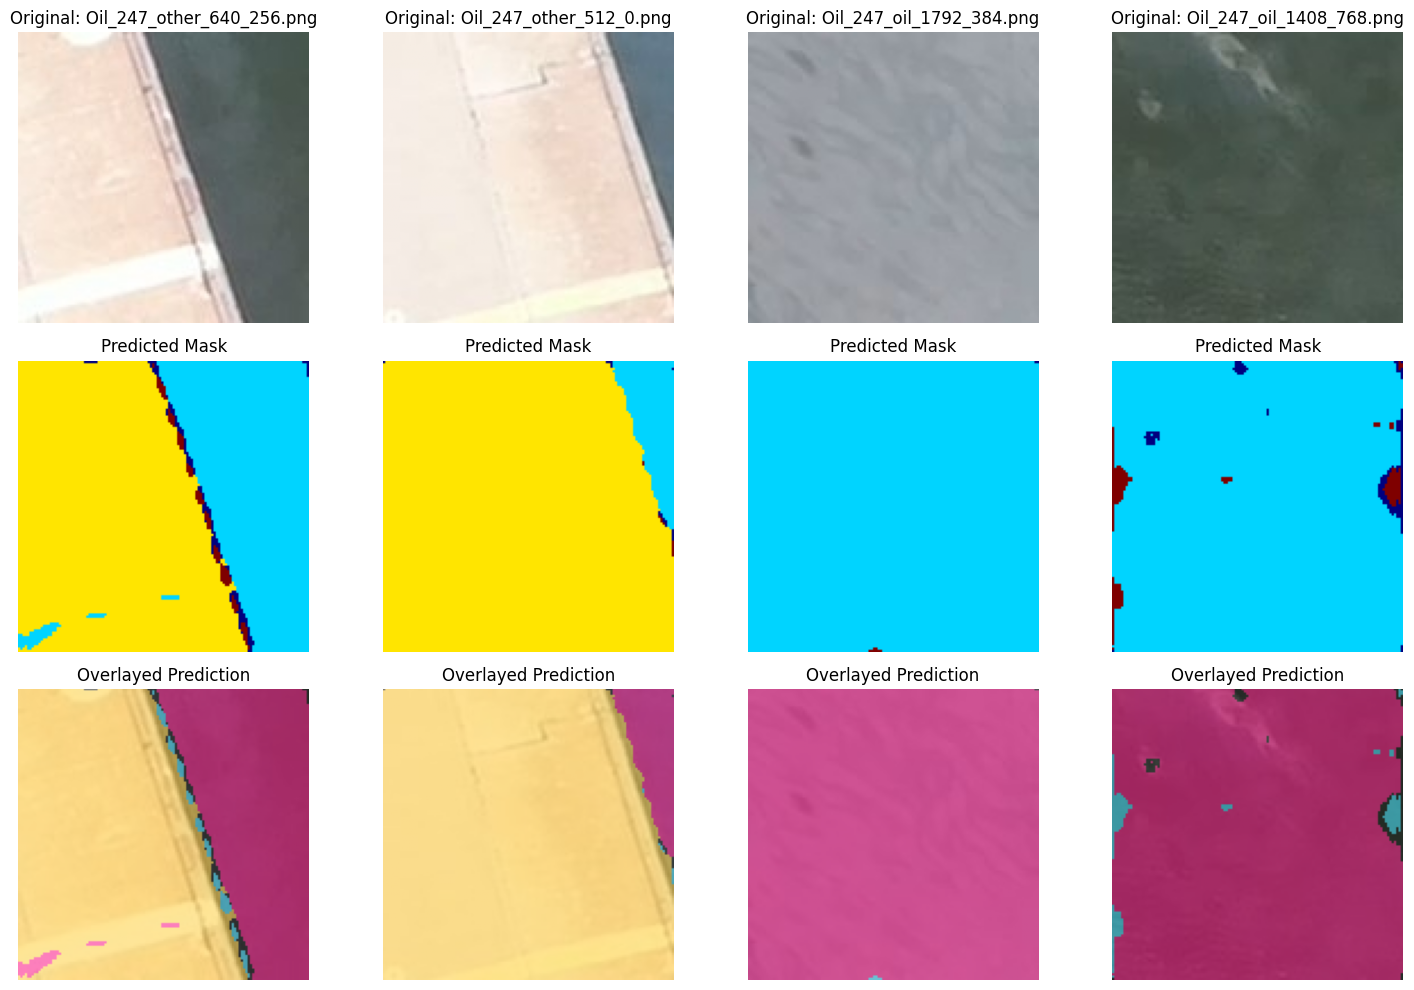

In [ ]:
# Display predictions
display_test_predictions(X_test_new, y_pred, image_names, num=4)


In [ ]:
import os
import matplotlib.pyplot as plt

def save_predicted_masks(X, y_pred, image_names, output_folder):
    """Save the predicted masks as image files with corresponding image names."""
    os.makedirs(output_folder, exist_ok=True)

    for i in range(len(X)):
        # Convert probabilities to class labels
        predicted_mask = convert_prediction_to_labels(y_pred[i])

        # Convert class labels back to RGB colors
        colored_mask = convert_labels_to_colors(predicted_mask)

        # Get the original image name from image_names list
        mask_name = os.path.splitext(image_names[i])[0] + "_mask.png"
        mask_path = os.path.join(output_folder, mask_name)

        # Save mask as an image
        plt.imsave(mask_path, colored_mask)

    print(f"✅ Masks saved in: {output_folder}")

# Define the path to save the masks
output_folder = "/content/predicted_masks"

# Ensure image_names is defined
image_names = os.listdir("/content/Testpatches/patches/images")  # Adjust this path if needed

# Save the masks
save_predicted_masks(X_test_new, y_pred, image_names, output_folder)


✅ Masks saved in: /content/predicted_masks


In [ ]:
import numpy as np

def calculate_iou(ground_truth_mask, predicted_mask):
    """
    Calculates the Intersection over Union (IoU) score.

    Args:
        ground_truth_mask: The ground truth mask as a NumPy array.
        predicted_mask: The predicted mask as a NumPy array.

    Returns:
        The IoU score as a float.
    """
    # Convert masks to binary (0 or 1)
    ground_truth_mask = ground_truth_mask.astype(bool)
    predicted_mask = predicted_mask.astype(bool)

    # Calculate intersection and union
    intersection = np.logical_and(ground_truth_mask, predicted_mask)
    union = np.logical_or(ground_truth_mask, predicted_mask)

    # Calculate IoU
    iou_score = np.sum(intersection) / np.sum(union)

    return iou_score

In [ ]:
import os
import cv2

ground_truth_masks = []
mask_folder = "/content/Testpatches/patches/masks"
for img_name in os.listdir(mask_folder):
    mask_path = os.path.join(mask_folder, img_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    ground_truth_masks.append(mask)

In [ ]:
iou_scores = []
for i in range(len(ground_truth_masks)):
    iou = calculate_iou(ground_truth_masks[i], convert_prediction_to_labels(y_pred[i])) # Assuming y_pred is your predictions. convert_prediction_to_labels() converts the prediction to labels
    iou_scores.append(iou)

mean_iou = np.mean(iou_scores)
print(f"Mean IoU: {mean_iou:.4f}")

Mean IoU: 0.8781
